In [1]:
# Import necessary libraries and modules
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import r2_score
from rdkit.Chem import Draw, PandasTools, rdMolDescriptors

# Custom utility functions
from utils import *


In [2]:
# Disable RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Introduction

This project implements a Python-based method for estimating the synthetic accessibility (SA) score, based on the paper *"The Estimation of Synthetic Accessibility Score of Drug-like Molecules"*, published in the *Journal of Cheminformatics*. 

The method combines molecular complexity and fragment contributions to calculate the SA score. Custom functions were developed for:

- Generating the fragment contribution dictionary,
- Calculating fragment scores, 
- Applying complexity penalties, and 
- Computing the final SA score.

These functions are stored in `utils.sa_score_calculator` and `utils.contribution_scores`. The fragment contribution dictionary was built using 1,000,000 molecules randomly sampled from PubChem. SA scores were then calculated for 40 molecules, with reference scores provided by chemists and the publication, followed by statistical analysis of the results.

# Calculation of Fragment Contributions Dictionary
This section focuses on calculating the contributions of molecular fragments using a large dataset of molecules. Analyzing common structural features found in previously synthesized molecules helps estimate their synthetic accessibility (SA). By examining the frequency of these fragments, we can capture "historical synthetic knowledge" and identify which structural features are easier or more challenging to synthesize.


In [3]:
# # Open and load the pickle file
# with open("data/million_molecules.pkl", "rb") as file:
#     million_molecules = pickle.load(file)
# print(f"Loaded {len(million_molecules)} molecules!")

In [4]:
# # Generate and calculate fragment counts on chunks of the dataset
# chunk_size = 10000
# total_fragment_counts = Counter()

# for i in range(0, len(million_molecules), chunk_size):
#     chunk = million_molecules[i:i + chunk_size]
#     chunk_fragment_counts = calculate_fragment_counts(chunk)
#     total_fragment_counts.update(chunk_fragment_counts)

Fragments were generated using **ECFP#4**, equivalent to Morgan Fingerprints with a radius = 2. A random sample of the first 1,000,000 molecules was taken from **PubChem**, obtained from the [NCBI PubChem FTP](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/).

- The fragment counts were precomputed from this dataset (with the commented code above)
- These counts were stored in a Counter object and saved as a pickle file for efficient reuse.

The precomputed counts are used to assign contribution scores, which form the basis for assessing the synthetic accessibility of new molecules.

In [5]:
# Load fragment counts from a pickle file
with open('data/total_fragment_counts.pkl', "rb") as file:
    total_fragment_counts = pickle.load(file)
print("Loaded existing fragment counts!")

Loaded existing fragment counts!


In [6]:
# Compute contribution scores based on fragment counts
contribution_scores = calculate_contribution_scores(total_fragment_counts)

## Analysis of Fragment Counts

In [7]:
# Total fragments
total_fragments = sum(total_fragment_counts.values())
# Number of singletons
num_singletons = sum(1 for count in total_fragment_counts.values() if count == 1)
# Percentage of singletons
percentage_singletons = (num_singletons / len(total_fragment_counts)) * 100 if len(total_fragment_counts) > 0 else 0
# Number of frequent fragments (score > 1000)
num_frequent_fragments = sum(1 for count in total_fragment_counts.values() if count > 1000)
# Calculate percentage of frequent fragments
percentage_frequent_fragments = (num_frequent_fragments / len(total_fragment_counts)) * 100 if len(total_fragment_counts) > 0 else 0
# Length of the fragment counts
num_fragments_types = len(total_fragment_counts)

# Print the results
print("Fragment Counts Analysis:")
print(f"- Total Fragments: {total_fragments}")
print(f"- Total Fragment Types: {num_fragments_types}")
print(f"- Singletons: {num_singletons} ({percentage_singletons:.2f}%)")
print(f"- Frequent Fragments (score > 1000): {num_frequent_fragments} ({percentage_frequent_fragments:.2f}%)")

Fragment Counts Analysis:
- Total Fragments: 63742517
- Total Fragment Types: 551409
- Singletons: 228013 (41.35%)
- Frequent Fragments (score > 1000): 3335 (0.60%)


### Observations
Altogether 551,409  different fragment types have been obtained by fragmenting the PubChem structures. Most of them (41.35%), are singletons (present only once in the whole set). Only a relatively small number of fragments, namely 3335 (0.6%), are frequent (i.e. present more than 1000-times in the database). The visualiztion below provides a logarithmic visualization of the frequency distribution of fragments, highlighting the skewed nature of the data, as many fragments occur very rarely (only a few times).

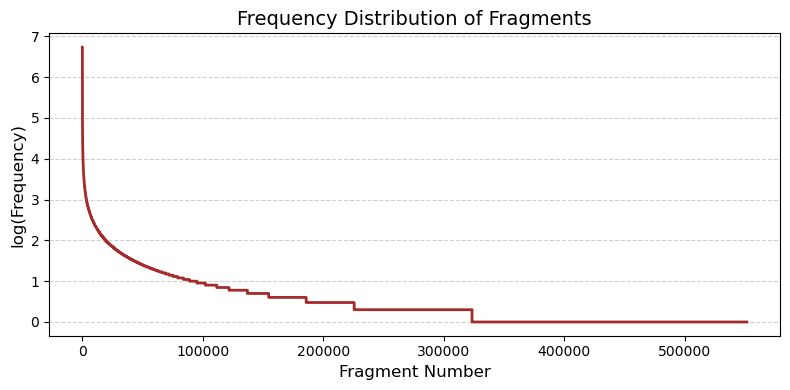

In [8]:
# Sort the frequencies in descending order
frequencies = sorted(total_fragment_counts.values(), reverse=True)

# Generate fragment numbers for the x-axis
fragment_numbers = range(1, len(frequencies) + 1)
log_frequencies = np.log10(frequencies)

# Plot the data
plt.figure(figsize=(8, 4))
plt.plot(fragment_numbers, log_frequencies, color='brown', linewidth=2, drawstyle='steps-post')

plt.xlabel("Fragment Number", fontsize=12)
plt.ylabel("log(Frequency)", fontsize=12)
plt.title("Frequency Distribution of Fragments", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

### Most Frequent Bits

In this section, the top 10 most frequent fragments from the dataset are selected and visualized using Morgan fingerprints. The `list_bits` object, containing the relevant molecular data and fingerprint information for these frequent fragments, was precomputed using the code below (which is commented out) and saved as a pickle file for efficiency.

In [9]:
# # Get the top 10 most frequent bits
# top_10_bits = [bit for bit, _ in total_fragment_counts.most_common(10)]
# bit_to_molecule = {}

# # Iterate over molecules to collect information for bit visualization
# for mol in million_molecules:
#     if len(bit_to_molecule) == 10:  # Stop when information for 10 bits is collected
#         break
    
#     bit_info = {}
#     fingerprint = rdMolDescriptors.GetMorganFingerprint(mol, radius=2, bitInfo=bit_info)
    
#     for bit in top_10_bits:
#         if bit in bit_info and bit not in bit_to_molecule:
#             bit_to_molecule[bit] = {
#                 'Molecule': mol,  # Store the molecular object instead of its ID
#                 'FingerprintInfo': bit_info[bit]
#             }

# # Sort the collected information by fragment count
# sorted_bit_to_molecule = {
#     bit: bit_to_molecule[bit]
#     for bit in sorted(bit_to_molecule.keys(), key=lambda x: total_fragment_counts[x], reverse=True)
# }

# # Prepare list of bits for visualization
# list_bits = [
#     (data['Molecule'], bit, {bit: [data['FingerprintInfo'][0]]}, 0)
#     for bit, data in sorted_bit_to_molecule.items()
# ]

In [10]:
# Load the precomputed list of bits
with open('data/list_bits.pkl', 'rb') as f:
    list_bits = pickle.load(f)

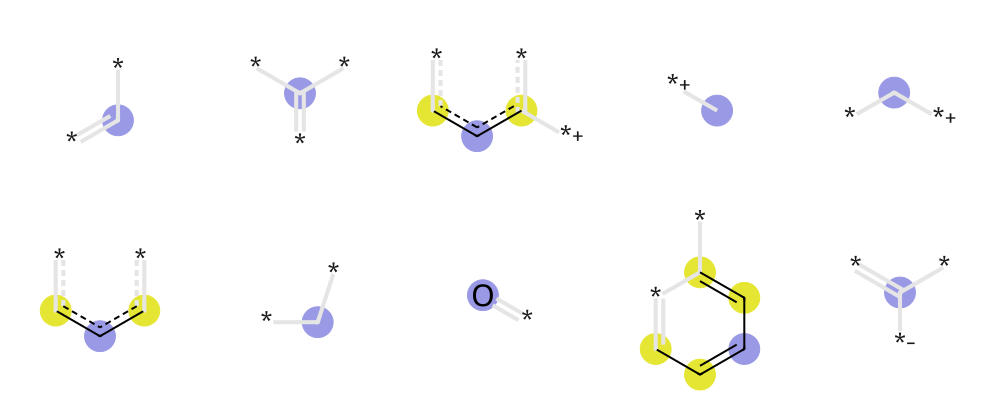

In [11]:
# Visualize most common bits
Draw.DrawMorganBits(list_bits, molsPerRow=5, subImgSize=(200, 200), useSVG=True)

## Analysis of Fragment Contributions


In [12]:
# Convert the dictionary values to a NumPy array for easier analysis
scores = np.array(list(contribution_scores.values()))

# Basic descriptive statistics
mean_score = np.mean(scores)
median_score = np.median(scores)
min_score = np.min(scores)
max_score = np.max(scores)

# Print the results
print("Basic Descriptive Statistics of Contribution Scores:")
print(f"- Mean: {mean_score}")
print(f"- Median: {median_score}")
print(f"- Minimum Score: {min_score}")
print(f"- Maximum Score: {max_score}")

Basic Descriptive Statistics of Contribution Scores:
- Mean: -5.747340683534822
- Median: -6.174827228410347
- Minimum Score: -6.8679744089702925
- Maximum Score: 8.647368542595153


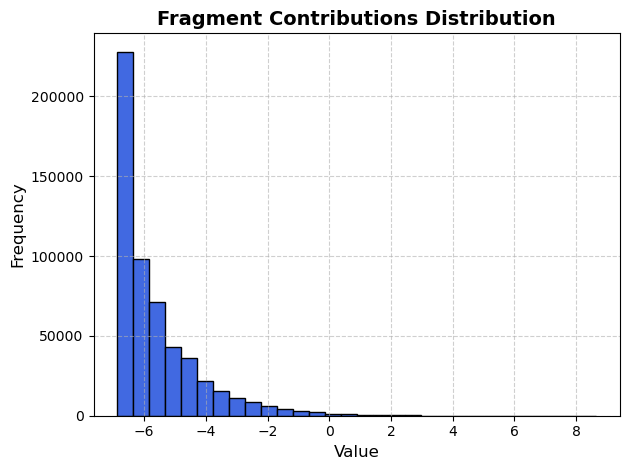

In [13]:
# Visualisation of distribution of contribution scores
plt.hist(scores, bins=30, edgecolor='black', color='royalblue')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Fragment Contributions Distribution', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Most of the fragments have negative contribution scores due to a significant number of singletons or fragments encountered only a few times. As a result, both the median and mean are low. 

- The mean of the contribution scores is **-5.75**, while the median is slightly lower at **-6.17**.
- The minimum score is **-6.87**, and the maximum score is **8.65**.

Despite the presence of outliers, they do not significantly affect the mean, as the distribution is highly right-skewed.


# Validation of Synthetic Accessibility (SA) Score

In the referenced study, 40 representative molecules were selected from the PubChem database and were evaluated by 9 chemists, who rated their ease of synthesis on a scale from 1 to 10. The average score provided by the chemists was recorded in the dataset (`40_molecules.csv`), along with the SA scores calculated using the researchers' method. Since the training datasets used to generate the contribution dictionary differ between the paper and this project, calculated SA scores are expected to be different.

In this section, the SA scores generated with my contribution dictionary will be compared against those obtained from the researchers', as well as the chemists' assessments, to evaluate the performance and validity of the synthetic accessibility predictions.

In [14]:
# Load the dataset
sample_40 = pd.read_csv("data/40_molecules.csv", sep='\t')

# Add a molecule column to the dataframe
PandasTools.AddMoleculeColumnToFrame(sample_40, smilesCol='SMILES', molCol="Mol")

# Calculate synthetic accessibility score for each molecule and store it in a new column
sample_40['mySAscore'] = sample_40['Mol'].apply(lambda molecule: calculate_sa(molecule, contribution_scores))

In [15]:
# Display the results
sample_40[['mySAscore', 'ChemistScore','SAscore']].head(5)

,mySAscore,ChemistScore,SAscore
0,1.107673,3.56,2.8063
1,3.973220,7.00,5.8937
2,1.136793,3.00,2.9996
3,1.413825,4.67,3.9366
4,1.191878,2.33,3.1260


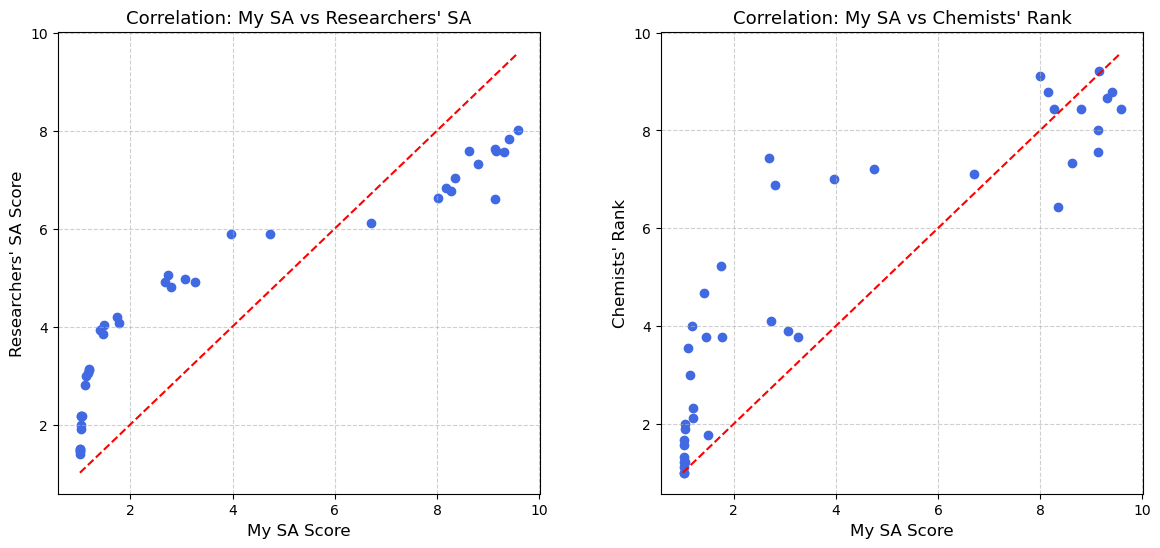

In [16]:
# Function to create scatter plot
def create_scatter_plot(ax, x_data, y_data, title, xlabel, ylabel):
    ax.scatter(x_data, y_data, color='royalblue')
    min_val = min(x_data.min(), y_data.min())
    max_val = max(x_data.max(), y_data.max())
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='x = y')
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Create the figure and grid for subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

create_scatter_plot(axes[0], sample_40['mySAscore'], sample_40['SAscore'], 
                    "Correlation: My SA vs Researchers' SA", "My SA Score", "Researchers' SA Score")

create_scatter_plot(axes[1], sample_40['mySAscore'], sample_40['ChemistScore'], 
                    "Correlation: My SA vs Chemists' Rank", "My SA Score", "Chemists' Rank")

plt.subplots_adjust(wspace=0.25)
plt.show()

The scatter plots show a strong positive correlation between my calculated SA scores and both the researchers' SA scores and the chemists' rankings.

In [17]:
# Calculate Pearson correlation coefficients
correlation_1 = sample_40['mySAscore'].corr(sample_40['SAscore'])
correlation_2 = sample_40['mySAscore'].corr(sample_40['ChemistScore'])

# Calculate R^2 for My SA Score vs Researchers' SA Score
actual_1 = sample_40['mySAscore']
predicted_1 = sample_40['SAscore']
r2_1 = r2_score(actual_1, predicted_1)

actual_2 = sample_40['mySAscore']
predicted_2 = sample_40['ChemistScore']
r2_2 = r2_score(actual_2, predicted_2)

std_mySAscore = sample_40['mySAscore'].std()
std_SAscore = sample_40['SAscore'].std()
std_ChemistScore = sample_40['ChemistScore'].std()


# Print correlation results with better formatting
print(f"--- Correlation Results ---")
print(f"My SA Score vs Researchers' SA Score: {correlation_1:.2f}")
print(f"My SA Score vs Chemists' Rank: {correlation_2:.2f}\n")

# Print R^2 results
print(f"--- R^2 Results ---")
print(f"R^2 for My SA Score vs Researchers' SA Score: {r2_1:.2f}")
print(f"R^2 for My SA Score vs Chemists' Rank: {r2_2:.2f}\n")

# Print standard deviation results
print(f"--- Standard Deviation Results ---")
print(f"My SA Score: {std_mySAscore:.2f}")
print(f"Researchers' SA Score: {std_SAscore:.2f}")
print(f"Chemists' Rank: {std_ChemistScore:.2f}")

--- Correlation Results ---
My SA Score vs Researchers' SA Score: 0.93
My SA Score vs Chemists' Rank: 0.89

--- R^2 Results ---
R^2 for My SA Score vs Researchers' SA Score: 0.76
R^2 for My SA Score vs Chemists' Rank: 0.73

--- Standard Deviation Results ---
My SA Score: 3.42
Researchers' SA Score: 2.21
Chemists' Rank: 2.90


---
- The strong correlations (0.93 and 0.89) indicate that My SA Score is closely aligned with both the Researchers' SA Score and the Chemists' Rank.  
- The R² values (0.76 and 0.73) suggest that My SA Score explains most of the variation in both.  
- The standard deviations show greater variability in My SA Score (3.42) compared to the Researchers' SA Score (2.21) and the Chemists' Rank (2.90).


# Conclusion

The project successfully calculates synthetic accessibility (SA) scores for molecules based on fragment contributions. It compares these calculated SA scores with existing researcher and chemist scores to evaluate their accuracy. The analysis shows strong correlations between the different scores, indicating that the model provides reliable estimates of synthetic accessibility. Overall, the project demonstrates the potential of using fragment-based contributions to predict how easily molecules can be synthesized.

# References
1. <a id="reference-1"></a> Ertl, P., Schuffenhauer, A. (2009). *The Estimation of Synthetic Accessibility Score of Drug-like Molecules*. Journal of Cheminformatics, 1, 8. [https://doi.org/10.1186/1758-2946-1-8](https://doi.org/10.1186/1758-2946-1-8)
2. PubChem. (n.d.). PubChem SDF data. National Center for Biotechnology Information. Retrieved December 5, 2024, from [https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/)
